We will look at the performance of Pnet against:
 - an equally sparse but randomly connected feed forward neural network (sparseNN)
 - a fully connected feed forward neural network (fcNN)
 - a random forest classifier model (RF)
 - a svm classifier model (SVM)

The benchmarking task is done on the original prostate dataset from the 2019 paper

### Loading the data

In [1]:
import pnet_loader
import util
import Pnet
import torch
import random
import seaborn as sns
import pandas as pd
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import torch.nn.functional as F
import torch.nn as nn


%load_ext autoreload
%autoreload 2

In [2]:
prostate_mutations = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/response_paper.csv')
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv('/mnt/disks/pancan/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

# prostate_mutations = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
# prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_cnv = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
# prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
# prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_response = pd.read_csv('../../data/pnet_database/prostate/processed/response_paper.csv')
# prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
# prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_genes = pd.read_csv('../../data/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
# prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

Generate train test splits for 10 fold CV, not to run again if saved splits are available

In [3]:
# prostate_inds = pnet_loader.get_indicies(genetic_data, prostate_response)
# random.shuffle(prostate_inds)

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]
        
# test_splits = chunks(prostate_inds, int(len(prostate_inds)/10)+1)
# for i, s in enumerate(test_splits):
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, test_inds=s)
#     train_dataset.save_indicies('../data/splits/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/test_set_{}.csv'.format(i))

In [4]:
# from sklearn.model_selection import StratifiedKFold

# prostate_inds = pnet_loader.get_indicies(genetic_data, prostate_response)
# y = list(prostate_response.loc[prostate_inds]['response'])
# # Assuming `y` contains the labels for your training data
# # and `prostate_inds` contains the indices of the training data
# # Make sure `y` and `prostate_inds` have the same length

# # Create an instance of StratifiedKFold with 10 splits
# skf = StratifiedKFold(n_splits=10)

# # Initialize an empty list to store the sublists of indices
# sublists = []

# # Split the indices into sublists stratified by labels
# for train_index, _ in skf.split(prostate_inds, y):
#     sublist = [prostate_inds[i] for i in train_index]
#     sublists.append(sublist)
    
# for i, s in enumerate(sublists):
#     s_ = [x for x in prostate_inds if x not in s]
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, train_inds=s, test_inds=s_)
#     train_dataset.save_indicies('../data/splits/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/test_set_{}.csv'.format(i))

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

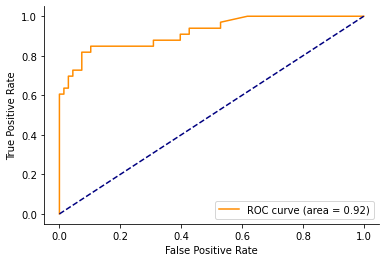

In [6]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_geneset(genetic_data, prostate_response, 
                                                                                     geneset_path='/mnt/disks/pancan/pnet/data/hallmark/h.all.v2022.1.Hs.symbols.gmt',
                                                                                     seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, 
                                                                                     save_path='../results/prostate_val_hallmark/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), genes=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_hallmark/run{}'.format(i))

In [7]:
# model.interpret_flag=True
# cond = captum.attr.LayerConductance(model, model.first_gene_layer)  # ReLU output of masked layer at each level
# cond_vals = cond.attribute((test_dataset.x, test_dataset.additional), target=0)
# cols = [model.reactome_network.pathway_encoding.set_index('ID').loc[col]['pathway'] for col in model.reactome_network.pathway_layers[0].index]
# cond_vals_genomic = pd.DataFrame(cond_vals.detach().numpy(),
#                                  columns=cols,
#                                  index=test_dataset.input_df.index)
# pathway_imp_by_target = cond_vals_genomic
# model.interpret_flag=False
# pathway_imp_by_target

In [8]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_hallmark/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc)
pnet_aucs

[tensor(0.8932),
 tensor(0.9004),
 tensor(0.8196),
 tensor(0.9140),
 tensor(0.8957),
 tensor(0.8870),
 tensor(0.9332),
 tensor(0.8632),
 tensor(0.8770),
 tensor(0.9189)]

In [14]:
torch.tensor(pnet_aucs).mean()

tensor(0.8967)

In [15]:
torch.tensor(pnet_aucs).mean()

tensor(0.8967)

Pnet performance:

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

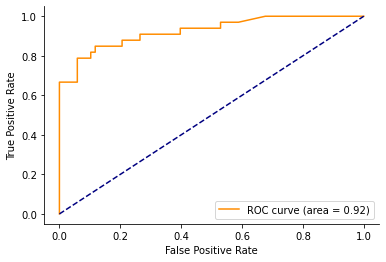

In [5]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val/run{}'.format(i))

In [17]:
# for i in range(10):
#     train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
#     test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
#     model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, lr=1e-3, weight_decay=1,
#                                                                            batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
#                                                                            test_inds=test_inds)
#     plt.clf()
#     Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val/run{}'.format(i))

In [18]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val/run{}/AUC_PRC.pt'.format(i))
    pnet_aucs.append(auc)
pnet_aucs

[0.8599059581756592,
 0.8801746368408203,
 0.798488974571228,
 0.8853947520256042,
 0.8627687096595764,
 0.8610366582870483,
 0.8441952466964722,
 0.7464096546173096,
 0.8494458198547363,
 0.8820420503616333]

In [19]:
torch.tensor(pnet_aucs).mean()

tensor(0.8470)

Pnet but with random gene and pathway connections:

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

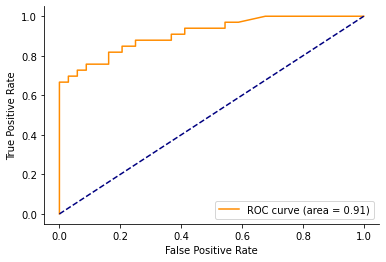

In [20]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val_random_net/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes, random_network=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_random_net/run{}'.format(i))

In [21]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_random_net/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.8901383876800537,
 0.9148375988006592,
 0.8792800307273865,
 0.936274528503418,
 0.8373440504074097,
 0.8672013878822327,
 0.8899286985397339,
 0.8658645153045654,
 0.8841354846954346,
 0.9117647409439087]

0.8850

In [22]:
torch.tensor(pnet_aucs).median()

tensor(0.8841)

Pnet but as a fully connected feed forward neural network:

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

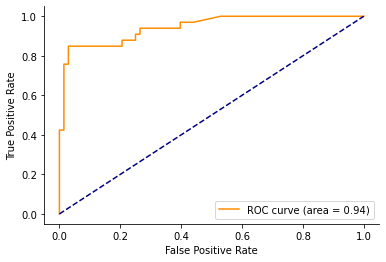

In [23]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val_fcnn/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes, fcnn=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_fcnn/run{}'.format(i))

In [24]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_fcnn/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.8771625757217407,
 0.9218611717224121,
 0.8107989430427551,
 0.897504448890686,
 0.9113190770149231,
 0.9021835327148438,
 0.9264705181121826,
 0.8462567329406738,
 0.8850266933441162,
 0.9438502192497253]

In [25]:
torch.tensor(pnet_aucs).median()

tensor(0.8975)

In [ ]:
for i in range(10):
    path = '../results/prostate_val_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=prostate_response, train_inds=train_inds, test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

In [26]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_rf/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.9035466909408569,
 0.9007901549339294,
 0.8557945489883423,
 0.8763368725776672,
 0.8879233598709106,
 0.8765597343444824,
 0.885026752948761,
 0.8611854314804077,
 0.8622994422912598,
 0.896390438079834]

In [27]:
torch.tensor(pnet_aucs).median()

tensor(0.8766)

In [ ]:
for i in range(10):
    path = '../results/prostate_val_svm/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=prostate_response, train_inds=train_inds, test_inds=test_inds)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    svm = SVC(gamma='auto', kernel='linear', probability=True)
    svm.fit(x_train, y_train)
    
    preds = svm.predict(x_test)
    preds_prob = svm.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = svm.coef_
    print(len(importances[0]))
    svm_importances = pd.Series(importances[0], index=test_dataset.input_df.columns)
    svm_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')
    

### Generate Figures

In [28]:
auc_df = pd.DataFrame()
models = ['prostate_val_random_net', 'prostate_val', 'prostate_val_fcnn']
for mod in models:
    aucs = []
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(mod, i))
        aucs.append(auc.item())
    auc_df[mod] = aucs
models = ['prostate_val_rf', 'prostate_val_svm']
for mod in models:
    aucs = []
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(mod, i))
        aucs.append(auc.item())
    auc_df[mod] = aucs
auc_df

auc_df = auc_df[auc_df.median().sort_values(ascending=False).index]
auc_df.rename(columns={'prostate_val': 'PNET', 'prostate_val_fcnn': 'FCNN', 'prostate_val_random_net': 'Sparse-NN',
       'prostate_val_svm': 'SVM', 'prostate_val_rf': 'RF'}, inplace=True)

In [29]:
auc_df.mean()

FCNN         0.892243
PNET         0.897395
Sparse-NN    0.887677
SVM          0.875403
RF           0.880585
dtype: float64

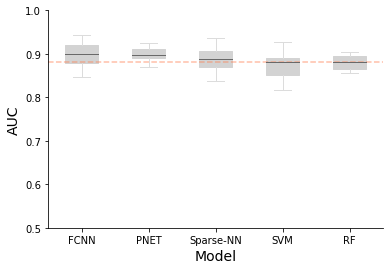

In [30]:
auc_df.plot(kind='box', showfliers=False, patch_artist=True, boxprops={'facecolor': 'lightgrey', 'color': 'lightgrey'},
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
plt.axhline(y=auc_df.median().min(), color='coral', linestyle='--', label=f'y_min = {auc_df.median().min()}', alpha=0.5)
ax.set_ylabel('AUC', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/pnet_performance_benchmark_AUC.pdf')

In [ ]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks

df_imps.mean(axis=1).nlargest(20)

In [ ]:
df_imps_rand = pd.DataFrame()
df_ranks_rand = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_random_net/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    ranks = imps.rank(ascending=False)
    df_imps_rand['run{}'.format(i)] = imps
    df_ranks_rand['run{}'.format(i)] = ranks

In [ ]:
df_imps_rf = pd.DataFrame()
df_ranks_rf = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_rf/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    ranks = imps.rank(ascending=False)
    df_imps_rf['run{}'.format(i)] = imps
    df_ranks_rf['run{}'.format(i)] = ranks
    
num_sections = 3
section_size = len(df_imps_rf) // num_sections

# Split the original DataFrame into three sub-sections
dfs = [df_imps_rf[i * section_size : (i + 1) * section_size] for i in range(num_sections)]

for df in dfs:
    df.index = [ind.split('_')[0] for ind in dfs[1].index]

# Sum the sub-sections element-wise to obtain the final DataFrame
df_imps_rf = dfs[0] + dfs[1] + dfs[2]

In [ ]:
plotting_df = pd.DataFrame()
custom_colors = {'P-Net': '#41B6E6', 'Sparse-NN': '#00629B', 'RF':'#FFA300'}
plotting_df['P-Net'] = df_imps.mean(axis=1).nlargest(10)/df_imps.mean(axis=1).sum()
plotting_df['Sparse-NN'] = df_imps_rand.loc[df_imps.mean(axis=1).nlargest(10).index].mean(axis=1)/df_imps_rand.mean(axis=1).sum()
plotting_df['RF'] = df_imps_rf.loc[df_imps.mean(axis=1).nlargest(10).index].mean(axis=1)/df_imps_rf.mean(axis=1).sum()
plotting_df.plot(kind='barh', color=custom_colors, width=0.8)
sns.despine()
plt.gca().invert_yaxis()
plt.xlabel('Gene Importance Score', size='14')
plt.xscale('log')
plt.savefig('../figures/prostate_metastatic_top_genes.pdf')

In [ ]:
df_ranks.mean(axis=1).nsmallest(20)

In [ ]:
rank_stab = {}
for m in ['val', 'val_fcnn', 'val_random_net', 'val_rf', 'val_svm']:
    df = pd.DataFrame()
    for i in range(10):
        imps = pd.read_csv('../results/prostate_{}/run{}/gene_feature_importances.csv'.format(m, i)).set_index('Unnamed: 0')
        m_imps = abs(imps).mean()
        df['run{}'.format(i)] = m_imps

    most_imp_50 = df.mean(axis=1).nlargest(50).index
    rank_stab[m] = df.loc[most_imp_50].std(axis=1).sum()
    # filtered_df = df[~(df > 20).any(axis=1)]
    # rank_stab[m] = filtered_df.shape[0]

In [ ]:
rank_stab = pd.Series(rank_stab).rename(index={'val': 'PNET', 'val_fcnn': 'FCNN', 'val_random_net': 'Sparse-NN',
       'val_svm': 'SVM', 'val_rf': 'RF'})

In [ ]:
df = pd.DataFrame(index=rank_stab.index)
df['AUC'] = auc_df.mean()
df['Rank Stability'] = rank_stab

In [ ]:
df.plot(kind='scatter', x='Rank Stability', y='AUC', color='#41B6E6')
sns.despine()
for index, row in df.iterrows():
    plt.annotate(index, (row['Rank Stability'], row['AUC']), xytext=(5, 0), textcoords='offset points', fontsize=12)
plt.ylim((0.85, 0.95))
plt.xlabel('Rank Stability', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('../figures/pnet_performance_rank_variance.pdf')
plt.show()

In [ ]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_hallmark/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks

df_imps.mean(axis=1).nlargest(20)

In [ ]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_hallmark/run{}/layer_0_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks

In [ ]:
rn = model.reactome_network
'CSMD3' in list(rn.genes2pathways[rn.genes2pathways['pathway'] == 'residual']['gene'])

In [ ]:
rn.genes2pathways.groupby('pathway').count().nlargest(20, 'gene')

In [ ]:
df_imps.mean(axis=1).nlargest(50)

In [ ]:
df_imps_rand = pd.DataFrame()
df_ranks_rand = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_random_net/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    df_imps_rand['run{}'.format(i)] = imps
    df_ranks_rand['run{}'.format(i)] = ranks

In [ ]:
'run1' > 'run0'

In [ ]:
def stability_score(imps, top_n):
    overlaps = []
    for c1 in imps.columns:
        for c2 in imps.columns:
            if c1 > c2:
                overlaps.append(len(set(imps.nlargest(top_n, c1).index).intersection(set(imps.nlargest(top_n, c2).index))))
    return sum(overlaps)/(imps.shape[1]*(imps.shape[1]-1)/2*top_n)

In [ ]:
n_genes = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 12, 14, 17, 20]
p_net_stab = [stability_score(df_imps, n) for n in n_genes]
r_net_stab = [stability_score(df_imps_rand, n) for n in n_genes]

plt_df = pd.DataFrame(index=n_genes)
plt_df['P-Net'] = p_net_stab
plt_df['Sparse-NN'] = r_net_stab

In [ ]:
plt_df.plot()
plt.ylabel('Gene Stability', size=14)
plt.xlabel('Top N genes considered', size=14)
sns.despine()

In [ ]:
all_imps = pd.DataFrame(columns=['Run', 'Importance', 'Model', 'Layer'])
for m in ['val', 'val_random_net']:
    for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2', 'layer_3']:
        df_imps = pd.DataFrame()
        df_ranks = pd.DataFrame()
        for i in range(10):
            imps = pd.read_csv('../results/prostate_{}/run{}/{}_importances.csv'.format(m, i, l)).set_index('Unnamed: 0')
            imps = abs(imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1])
            ranks = imps.rank(ascending=False)
            df_imps['run{}'.format(i)] = imps
            df_ranks['run{}'.format(i)] = ranks
        melted_imps = df_imps.melt(value_name='Importance', var_name='Run')
        melted_imps['Model'] = m
        melted_imps['Layer'] = l
        all_imps = pd.concat([all_imps, melted_imps])
all_imps

In [ ]:
layer_numeric = {'gene_feature':0, 'gene':1, 'layer_0':2, 'layer_1':3, 'layer_2':4, 'layer_3':5}

In [ ]:
all_imps['Numeric Layer'] = all_imps['Layer'].apply(lambda x: layer_numeric[x])

In [ ]:
plt.figure(figsize=(24, 16))
sns.scatterplot(data=all_imps, y='Importance', x='Numeric Layer', hue='Model')
plt.show()

In [ ]:
import numpy as np

In [ ]:
grpd_df = all_imps.groupby(['Numeric Layer', 'Model']).mean().reset_index()
std_df = all_imps.groupby(['Numeric Layer', 'Model']).std().reset_index()
grpd_df['Importance'] = grpd_df['Importance']/std_df['Importance']

In [ ]:
sns.lineplot(data=grpd_df, x='Numeric Layer', y='Importance', hue='Model')
plt.legend(['P-Net', 'Random Sparse Net'])
plt.ylabel('SNR of Importance Scores', size=14)
plt.xlabel('Network Layer', size=14)
sns.despine()
plt.savefig('../figures/importance_scores_per_layer_SNR.pdf')

In [ ]:
def plot_violin(dataframe, title, ax):
    melted_df = dataframe.melt(var_name='Columns', value_name='Values')
    sns.violinplot(y='Values', data=melted_df, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Columns', size=14)
    ax.set_ylabel('Values', size=14)

# Create subplots for each violin plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax2.spines[['top','left','right']].set_visible(False)
ax1.spines[['top','right']].set_visible(False)
ax2.yaxis.set_visible(False)
# Plot the first DataFrame as violin plot
plot_violin(df_imps, title='P-Net', ax=ax1)

# Plot the second DataFrame as violin plot
plot_violin(df_imps_rand, title='Sparse-NN', ax=ax2)

In [ ]:
df_imps_rand.mean(axis=1).nlargest(20)

In [ ]:
import numpy as np

In [ ]:
row_times_dist = (np.random.randn(350000)*9)+210

In [ ]:
sns.histplot(row_times_dist, bins=20)
plt.show()

In [ ]:
def get_row_ranks(row_time):
    row_ranks = (row_times_dist[:int(row_times_dist.shape[0]/35)*35].reshape(35, -1) < row_time).sum(axis=0)+1
    return row_ranks

In [ ]:
amrap_row_pace = (np.random.randn(10000)*7)+255
amrap_vup_pace = (np.random.gamma(3, 10, 10000)) + 30
amrap_ctb_pace = (np.random.gamma(3, 45, 10000)) + 40

In [ ]:
amrap_scores=[]
for athlete in range(350000):
    t = 18*60
    i = 0
    row = np.random.choice(amrap_row_pace)
    vup = np.random.choice(amrap_vup_pace)
    ctb = np.random.choice(amrap_ctb_pace)
    # print('Time for Row: {}, Time for Vup: {}, Time for C2B: {}'.format(row, vup, ctb))
    next_ex = list(zip(['r', 'v', 'c']*10, [row, vup, ctb]*10))
    
    while t>next_ex[i][1]:
        t -= next_ex[i][1]
        i += 1
    
    add_score = [1000, 30, 30]
    full_rounds = int(i/3)
    ex_comp = i%3
    add_reps = t/next_ex[i][1]*add_score[ex_comp]
    score = full_rounds*1060 + sum(add_score[:ex_comp])+int(add_reps)
    # print('Rounds completed: {}, Exercises completed: {}, Remaining time: {}, Reps achieved: {}, Total Score: {}'.format(i, ex_comp, t, add_reps, score))
    amrap_scores.append(score)
amrap_scores = np.array(scores)

In [ ]:
sns.histplot(amrap_scores, bins=30, stat='probability')
sns.despine()
plt.xlabel('Reps')
plt.show()

In [ ]:
def get_amrap_ranks(score):
    amrap_ranks = (amrap_scores[:int(amrap_scores.shape[0]/35)*35].reshape(35, -1) > score).sum(axis=0)+1
    return amrap_ranks

In [ ]:
x_row = np.linspace(180, 240, num=61)
x_amrap = np.linspace(2000, 3300, num=1301)
row_results = [get_row_ranks(xs).mean() for xs in x_row]
amrap_results = [get_amrap_ranks(xs).mean() for xs in x_amrap]


In [ ]:
plt.plot(x_row, row_results)

In [ ]:
plt.plot(x_amrap, amrap_results)
plt.gca().invert_yaxis()

In [ ]:
def overall_rank_outcome(row_time, amrap_score):
    return get_row_ranks(row_time).mean() + get_amrap_ranks(amrap_score).mean()

In [ ]:
x_row_grid, x_amrap_grid = np.meshgrid(x_row, x_amrap)


# Calculate the results for all points in the grid
results = np.zeros((len(x_row), len(x_amrap)))

# Evaluate the function for each combination of x_row and x_amrap
for i, row_value in enumerate(x_row):
    for j, amrap_value in enumerate(x_amrap):
        results[i, j] = overall_rank_outcome(row_value, amrap_value)

In [ ]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface plot
surf = ax.plot_surface(x_row_grid, x_amrap_grid, results.T, cmap='viridis')

# Set labels for each axis
ax.set_xlabel('X Row')
ax.set_ylabel('X AMRAP')
ax.set_zlabel('Results')

# Make the plot interactive (for Jupyter Notebook or JupyterLab)
%matplotlib inline

# Show the plot
plt.show()

In [ ]:
x_amrap_grid.shape